# We will be fine-tuning ResNet50 model (pre-trained with VGGFace2 weights) to perform facial expression classification on FER2013 dataset. 

## Install necessary python packages 

Run the below commands if these packages are not installed in your system. 

- pip install pandas
- pip install torch
- pip install -U scikit-learn

For visualisation

- pip install matplotlib
- pip install seaborn

You can also use conda to install the packages.

## Obtaining the data 
Download the data from the below link (icml_face_data.csv) and save it in the project folder </br>  
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data?select=icml_face_data.csv


## Running in colab

This code uses GPU and can be ran on Google Colab. 
Steps:
- Upload the project folder to your Google Drive along with this notebook
- Open this project with Google Colaboratory
- At Runtime option, click on Change Runtime type and Change it from None to GPU.

You are good to go! Start implementing the code below.

## Credits

- https://www.kaggle.com/alinaspasskaya/lab-2-face-emotion-classification-with-mlp
- https://www.kaggle.com/sharadhaviswanathan/imageclassification-facialexpression
- https://github.com/cydonia999/VGGFace2-pytorch/


In [2]:
from google.colab import drive

The below command will ask to choose the Gmail account that needs to be accessed in this project, choose the one where you have uploaded the data. You will recieve a password which needs to be entered to proceed.

In [3]:
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


## Import packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import f1_score
from torch.utils import data
import torchvision.transforms

## torch packages
import torch
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
import pickle

## Obtaining and Preprocessing the data

In data preparation the first step will be getting the train, validation and test splits of the data and this applies across all the modalities.  

Preprocessing the dataset varies based on both dataset and the model architecture in place. For example, the current ResNet pre-trained model architectute accepts three channel images with size 224x224 and we need to resize our images in that format. 

As FER2013 contains grayscale images, we repeat the same image in all the three channels, this is basic method of conversion.




In [5]:
data_path = "/content/gdrive/MyDrive/is4152_tutorial/icml_face_data.csv"
data = pd.read_csv(data_path) ## Grayscale images

# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']


def parse_data(data):
    
    image_array = np.zeros(shape=(len(data), 48, 48, 3))
    image_label = np.array(data["emotion"].values) 
    
    for i, row in enumerate(data.index):
        
        ## .loc indexes the pandas row based on the index
        image = np.fromstring(data.loc[row, ' pixels'], dtype=np.uint8, sep=' ') 
        image = np.reshape(image, (48, 48))
        
        ## making input size similar to input size of the pre-trained model 
        conv_image = np.empty((48,48,3))  
        conv_image[:, :, 0] = image
        conv_image[:, :, 1] = image
        conv_image[:, :, 2] = image
      
        image_array[i, :, :, :] = conv_image

    return image_array, image_label

# Splitting the data into train, validation and testing set thanks to Usage column
train_imgs, train_lbls = parse_data(data[data[" Usage"] == "Training"])
val_imgs, val_lbls = parse_data(data[data[" Usage"] == "PublicTest"])
test_imgs, test_lbls = parse_data(data[data[" Usage"] == "PrivateTest"])

## Structuring the dataset to pass it through a dataloader in Pytorch

The below code creates a custom Pytorch dataset which helps the dataloader to access the data to create the batches. In \_get_item\_ we can apply random augmentations to some of training images to prevent overfitting. 

In [6]:
class FER2013_Dataset(torch.utils.data.Dataset):
    
    def __init__(self,imgs,labels,training=False):

        self.imgs = imgs
        self.labels = labels
        self.training = training
    def __len__(self):
        
        return len(self.imgs)
    
    def __getitem__(self, index):
        
        img = self.imgs[index].astype(np.uint8)

        if self.training:
            
            img = torchvision.transforms.ToPILImage()(img)
            img = torchvision.transforms.Resize((224,224))(img)
            img = torchvision.transforms.RandomHorizontalFlip(p=0.5)(img) ## random flipping to prevent overfitting
            img = torchvision.transforms.ToTensor()(img)

        else:
            
            img = torchvision.transforms.ToTensor()(img)
            img = torchvision.transforms.Resize((224,224))(img)
            
        label = self.labels[index]
        return img, label

    
train_dataset = FER2013_Dataset(train_imgs, train_lbls,training=True)
valid_dataset = FER2013_Dataset(val_imgs, val_lbls)
test_dataset = FER2013_Dataset(test_imgs, test_lbls)

## Initialise the model architecture. 

Initialise the model architecture, here we are using Resnet50 architecture. Please check out https://github.com/cydonia999/VGGFace2-pytorch/ to get architecure.

In [7]:
import torch.nn as nn
import math
import torch
import torch.nn.functional as F
__all__ = ['ResNet', 'resnet50']

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, include_top=True):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.include_top = include_top
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.head = nn.Linear(512 * block.expansion,128)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        
        if not self.include_top:
            return x
        
        x = x.view(x.size(0), -1)
        feat = F.normalize(self.head(x), dim=1)

        x = self.fc(x)
        return x,feat

def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model

After intialising the model architecture, we load the pre-trained weights of this model trained on a larger related dataset, here we are using VGGFace2. Download the pretrained weights from https://github.com/cydonia999/VGGFace2-pytorch. 

Store the weight file in the same folder as the project. After initialising the model we load the pre-trained weights. 

include_top is to indicate for a classification head and this is dependant on the number of classes we have and the weights of which is randomly initialised as its task specific. To make the last layer match the nummber of classes we modify only the last layer of the model i.e self.fc.

In [8]:
def load_state_dict(model, fname):
    """
    Set parameters converted from Caffe models authors of VGGFace2 provide.
    See https://www.robots.ox.ac.uk/~vgg/data/vgg_face2/.
    Arguments:
        model: model
        fname: file name of parameters converted from a Caffe model, assuming the file format is Pickle.
    """
    with open(fname, 'rb') as f:
        weights = pickle.load(f, encoding='latin1')

    own_state = model.state_dict()


    for name, param in weights.items():

        if not "fc." in name:  ## copy weights for all layers except the classification head
            if name in own_state:
                own_state[name].copy_(torch.from_numpy(param))

weight_file ="/content/gdrive/MyDrive/is4152_tutorial/resnet50_scratch_weight.pkl"
model = resnet50(num_classes=len(emotion_labels), include_top=True)
model = model.cuda()
load_state_dict(model, weight_file)

 <font color='red'> <b> >> CHANGE THE PARAMETERS IN THE BELOW CELL</font>

## Getting things ready for training

A fairly general checklist,

1. Parmeter settings
2. Choose the model - ResNet50
3. Initialise the data loaders using the created dataset
4. Loss function - Cross-entropy 
5. Optimiser - SGD 
6. Learning rate scheduler  - Step LR Scheduler

Please set the random seed to help get same results for every run in a particular machnine. 
    
###### Do note that the choice of the items in this checklist is highly dependant on your choice of task, model and data.

In [9]:
## SET THE SEED FOR GETTING THE SAME RESULTS AGAIN
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)

model_arch = "resnet50"

## Parameter settings
nepoch = 10
learning_rate = 0.001
step_size = 5 ## reduce lr at steps of how many epochs
gamma = 0.5 ## how much learning rate to be reduced (lr*gamma after every <step size> epochs)
momentum = 0.9

batch_size = 64
output_size = len(emotion_labels)
    

# DATA LOADER

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size,shuffle= True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size = 1,shuffle= False)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = 1,shuffle= False)

# LOSS
loss_fn = nn.CrossEntropyLoss()  ## applies softmax to the logits before computing the loss 
loss_fn = loss_fn.cuda()

# OPTIMISER
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=momentum)
        
# LR SCHEDULER : STEP
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size,gamma=gamma)



## Training

The training dataset is divided into batches by the dataloader. All the weights of the model are fine-tuning (You can also try partial fine-tuning i.e freezing the bottom layers and fine-tuning the top layers). 

Here, we choose the best model based on the validation performance (accuracy). The best validation accuracy for comes around ~70%


Currently the model is ran for "nepoch" number of times, early stopping can be employed to prevent overfitting. Approximate time taken for an epoch is 9-10 min. 

In [ ]:
for epoch in range(nepoch):  # loop over the dataset multiple times
    train_loss = 0
    train_acc = 0
    best_criterion = 0
    count = 0
    ## model in training mode
    model.train()
    for data in tqdm(train_loader,total=len(train_loader)):
     
        inputs, target = data
        inputs, target = inputs.cuda(), target.cuda()
#         print(inputs.size())
        ## to clear accumulated gradients
        optimizer.zero_grad()

        outputs,feature = model(inputs)
        loss = loss_fn(outputs,target)
        
        ## computes the gradients
        loss.backward()
        ## updates the parameters
        optimizer.step()
        
        train_loss += loss.item()
        
        pred = torch.argmax(outputs,dim=1)
       
        num_correct = (pred==target).sum().item()
        train_acc += num_correct/inputs.size()[0]
        count += 1
    
    val_acc = 0
    val_loss = 0
    ## model in evaluation mode
    model.eval()
    
    
    with torch.no_grad(): ## disables gradient calculation
        
        for data in valid_loader:
            inputs, target = data
            inputs, target = inputs.cuda(), target.cuda()
            outputs,feature = model(inputs)
            loss = loss_fn(outputs, target)
            
            ## takes the class with high predicition probability
            pred = torch.argmax(outputs,dim=1)
       
            num_correct = (pred==target).sum().item()
            
            val_acc += num_correct/inputs.size()[0]
            val_loss += loss.item()
            
    print("Epoch:{} Train Loss:{:.2f} Train Accuracy:{:.2f} Val Loss:{:.2f} Val Accuracy:{:.2f}".format(epoch,train_loss/len(train_loader),(train_acc/len(train_loader))*100,val_loss/len(valid_loader),(val_acc/len(valid_loader))*100))
    
    ## Saves the best model by tracking the validation accuracy
    if val_acc > best_criterion:
        torch.save(model.state_dict(),"/content/gdrive/MyDrive/is4152_tutorial/{}_model_best.pth.tar".format(model_arch))

    best_criterion = max(best_criterion,val_acc)
    lr_scheduler.step()

    

  0%|          | 0/449 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 449/449 [09:17<00:00,  1.24s/it]


Epoch:0 Train Loss:1.05 Train Accuracy:60.97 Val Loss:0.92 Val Accuracy:65.45


100%|██████████| 449/449 [09:17<00:00,  1.24s/it]


Epoch:1 Train Loss:0.77 Train Accuracy:71.39 Val Loss:0.91 Val Accuracy:67.37


100%|██████████| 449/449 [09:16<00:00,  1.24s/it]


Epoch:2 Train Loss:0.64 Train Accuracy:75.93 Val Loss:0.93 Val Accuracy:67.62


100%|██████████| 449/449 [09:16<00:00,  1.24s/it]


Epoch:3 Train Loss:0.52 Train Accuracy:81.20 Val Loss:0.97 Val Accuracy:68.46


100%|██████████| 449/449 [09:16<00:00,  1.24s/it]


Epoch:4 Train Loss:0.41 Train Accuracy:85.60 Val Loss:1.03 Val Accuracy:68.26


100%|██████████| 449/449 [09:17<00:00,  1.24s/it]


Epoch:5 Train Loss:0.25 Train Accuracy:91.82 Val Loss:1.08 Val Accuracy:69.41


100%|██████████| 449/449 [09:18<00:00,  1.24s/it]


Epoch:6 Train Loss:0.17 Train Accuracy:94.86 Val Loss:1.18 Val Accuracy:70.21


100%|██████████| 449/449 [09:19<00:00,  1.25s/it]


Epoch:7 Train Loss:0.13 Train Accuracy:96.15 Val Loss:1.28 Val Accuracy:69.99


100%|██████████| 449/449 [09:19<00:00,  1.25s/it]


Epoch:8 Train Loss:0.10 Train Accuracy:97.23 Val Loss:1.42 Val Accuracy:69.16


100%|██████████| 449/449 [09:20<00:00,  1.25s/it]


Epoch:9 Train Loss:0.08 Train Accuracy:97.97 Val Loss:1.42 Val Accuracy:70.52


## Testing

In the testing phase,the weights of the best model from the training phase is loaded to get the evaluation performance on the test dataset. The best test accuracy  comes around ~72%. The state-of-the-art model in FER2013 gets about 75 -76 % accuracy.

We also measure the weighted F1 score, we use the weighted version due imbalance in the class distribution. 



In [11]:
model = "resnet50"
model = resnet50(num_classes=len(emotion_labels), include_top=True)
model = model.cuda()

conf_matrix = torch.zeros(output_size,output_size) ## CONFUSION MATRIX
total_num_samples = torch.zeros(output_size) ## KEEPS COUNT OF TOTAL NUMBER OF SAMPLES PER CLASS

model.load_state_dict(torch.load("/content/gdrive/MyDrive/is4152_tutorial/{}_model_best_full.pth.tar".format(model_arch)))
model.eval()

test_acc = 0
total = 0
y_pred,y_true = [],[]

model.eval()

with torch.no_grad():
    for data in test_loader:
        inputs, target = data
        inputs, target = inputs.cuda(), target.cuda()

        outputs,feature = model(inputs)

        pred = torch.argmax(outputs,dim=1)

        num_correct = (pred==target).sum().item()

        test_acc += num_correct/inputs.size()[0]
        
        
        for t, p in zip(target.data, pred):
            conf_matrix[t.long(), p.long()] += 1
            total_num_samples[t.long()] +=1
    
        y_pred.extend(pred.data.detach().cpu().tolist())
        y_true.extend(target.data.detach().cpu().tolist())
            
## Weighted F1 score calculation, can change the average to "macro" for the unweighted version

test_f1 = f1_score(y_true, y_pred, labels=list(range(0,output_size)),average='weighted')

print("Test Accuracy: {:.2f} Test F1: {:.2f}".format((test_acc/len(test_loader))*100,(test_f1)*100))

Test Accuracy: 72.36 Test F1: 72.30


## Visualisation : Confusion matrix

Confusion matrix helps visualise the misclassifications amongst the classes. Here, the confusion matrix is normalised by dividing each row with total number of samples in the class represented by the row. The diagonals of the matrix gives the per class accuracy of each class.


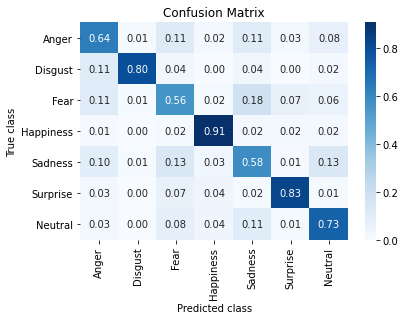

In [12]:
import seaborn as  sns

## NORMALISING THE CONFUSION MATRIX
normalised_conf_matrix = torch.div(conf_matrix,total_num_samples.unsqueeze(-1)) 

ticklabels = emotion_labels
sns.heatmap(normalised_conf_matrix,annot=True, fmt=".2f",xticklabels=ticklabels,yticklabels=ticklabels,cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted class")
plt.ylabel("True class")

plt.show()
